In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

import Constants as C
from PlotTool import PlotTool
from Loader import Loader
from Cuts import qlayerCut, firstHitInOuter

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss


In [61]:
# Load the data and apply the baseline selection.  Keep only
# the features we are going to use

b_features = ['hs_z_travel',
              'rho_travel',
              'tlarge5[0]-tearly5[0]',
              #'hm_nhit_doms',
              #'q_onstring-q_largest',
              'log10(hs_q_tot_pulses)',
              #'widthlarge5[0]',
              #'risetimelarge5[0]',
              #'widthlarge5[1]',
              #'risetimelarge5[1]',
              ]

# Weigth branches for book keeping
weights = ['w','wE2','PrimaryNeutrinoEnergy','OneWeight','NEvents']

# Define the baseline selection
basesel = "(!passHESE && hs_q_tot_pulses > 1000 && hm_nhit_doms > 50)"
L3 = "&&(rho_travel < 250 && hs_z_travel > -100 && hs_z_travel < 100 && tlarge5[0]-tearly5[0] < 200)"
basesel += L3

# Get data
loader = Loader(basesel)
d_nue  = loader.getNuE() 
d_cor  = loader.getCorsika()

# Insert the targets
d_nue['target'] = pd.Series(np.ones(len(d_nue['w']),dtype=int), index=d_nue.index)
d_cor['target'] = pd.Series(np.zeros(len(d_cor['w']),dtype=int), index=d_cor.index)

# Want to keep astro weights as well. Insert dummy astro
d_cor['wE2'] = pd.Series(np.zeros(len(d_cor['w']),dtype=float), index=d_cor.index)
d_cor['PrimaryNeutrinoEnergy'] = pd.Series(np.zeros(len(d_cor['w']),dtype=float), index=d_cor.index)

# Select outer events only
d_nue = qlayerCut(d_nue,False,0.8)
d_cor = qlayerCut(d_cor,False,0.8)

# Only keep events that have hit in outer list
d_nue = firstHitInOuter(d_nue)
d_cor = firstHitInOuter(d_cor)

# Separate high energy and low energy
d_he_nue = d_nue[np.log10(d_nue['PrimaryNeutrinoEnergy']) >= 6] 
d_le_nue = d_nue[np.log10(d_nue['PrimaryNeutrinoEnergy']) < 6]

# Select off only the features we want for training
d_he_nue = d_he_nue[ b_features + weights +['target'] ]
d_le_nue = d_le_nue[ b_features + weights +['target'] ]
d_cor    = d_cor[ b_features + weights + ['target'] ]


In [62]:
# Break into testing and training data sets
trainfrac = 0.6
X_nue_train, X_nue_test, y_nue_train, y_nue_test = train_test_split(d_he_nue[b_features+weights],
                                                                    d_he_nue['target'],
                                                                    train_size=trainfrac,
                                                                    random_state=194637)

X_cor_train, X_cor_test, y_cor_train, y_cor_test = train_test_split(d_cor[b_features+weights],
                                                                    d_cor['target'],
                                                                    train_size=trainfrac,
                                                                    random_state=194637)

# Now mix sig and bkg
X_train = X_nue_train.append(X_cor_train)
X_test  = X_nue_test.append(X_cor_test)
y_train = y_nue_train.append(y_cor_train)
y_test  = y_nue_test.append(y_cor_test)

# Adjust the weights
X_train['w'] *= 1/trainfrac
X_test['w']  *= 1/(1-trainfrac)

X_train['wE2'] *= 1/trainfrac
X_test['wE2']  *= 1/(1-trainfrac)

print "-------------------------"
print "Consistency check:"
print "Corsika: ", sum(X_train[ y_train < 0.5 ]['w']), sum(X_test[ y_test < 0.5 ]['w']) 
print "E^-2:    ", sum(X_train[ y_train > 0.5 ]['wE2']), sum(X_test[ y_test > 0.5 ]['wE2'])


-------------------------
Consistency check:
Corsika:  12388.3796319 14798.1159707
E^-2:     0.331437910165 0.330021194767


In [34]:
# Ok now we have our data separated and we can train our classifier
# In a separate script, do a grid search to best determine the hyper parameters.
# Here we can train the classifier

# Hyper params (not optimized yet):
ntrees       = 500
maxdepth     = 3
minsplit     = 10000
learningrate = 0.2


# Using a BDT for now
decisiontree = DecisionTreeClassifier(max_depth=maxdepth,
                                      min_samples_split=minsplit)
clf = AdaBoostClassifier(decisiontree,
                         n_estimators=ntrees,
                         learning_rate=learningrate,
                         algorithm='SAMME')

# Train it
clf.fit(X_train[ b_features ], y_train)


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=10000, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=0.2, n_estimators=500, random_state=None)

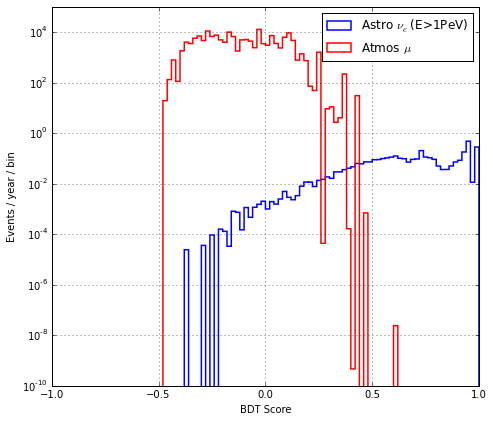

Cut: 0.1
	Corsika: 18936.620448
	Astro:   3.450948
Cut: 0.15
	Corsika: 4765.321540
	Astro:   3.444246
Cut: 0.2
	Corsika: 1999.997556
	Astro:   3.422671
Cut: 0.25
	Corsika: 1398.245863
	Astro:   3.395871
Cut: 0.3
	Corsika: 269.143187
	Astro:   3.356460
Cut: 0.35
	Corsika: 255.387341
	Astro:   3.299940
Cut: 0.4
	Corsika: 30.518781
	Astro:   3.204050
Cut: 0.45
	Corsika: 0.000698
	Astro:   3.063875
Cut: 0.5
	Corsika: 0.000000
	Astro:   2.886352
Cut: 0.55
	Corsika: 0.000000
	Astro:   2.657462
Cut: 0.6
	Corsika: 0.000000
	Astro:   2.389278
Cut: 0.65
	Corsika: 0.000000
	Astro:   2.113363
Cut: 0.7
	Corsika: 0.000000
	Astro:   1.901133
Cut: 0.75
	Corsika: 0.000000
	Astro:   1.532384
Cut: 0.8
	Corsika: 0.000000
	Astro:   1.287570
Cut: 0.85
	Corsika: 0.000000
	Astro:   1.182810
Cut: 0.9
	Corsika: 0.000000
	Astro:   1.041445
Cut: 0.95
	Corsika: 0.000000
	Astro:   0.298751


In [43]:
# At this point we have the trained BDT so we can analyze the results
import matplotlib.pyplot as plt
pt = PlotTool()

# Get the scores
X_test['scores'] = pd.Series(clf.decision_function(X_test[b_features]),
                            index = X_test.index)

# Divide up sig and bkg
dt_sig = X_test[ y_test > 0.5 ]
dt_bkg = X_test[ y_test < 0.5 ]

# Not plot them
sf = 365/34.7
fig,ax = plt.subplots(ncols=1,figsize=(7,6))
pt.ploth1(dt_sig['scores'].as_matrix(),
          dt_sig['wE2'].as_matrix() * sf,
          'BDT Score','Events / year / bin',
          r'Astro $\nu_{e}$ (E>1PeV)',
          100,-1,1,'b',
          False,False)
pt.ploth1(dt_bkg['scores'].as_matrix(),
          dt_bkg['w'].as_matrix() * sf,
          'BDT Score','Events / year / bin',
          r'Atmos $\mu$',
          100,-1,1,'r',
          False,False)

plt.grid()
plt.legend(loc='best')
ax.set_yscale('log')
plt.savefig('../plots/mvaana/EffectiveArea/firstpass.png')

plt.show()

# Let's also print out the expected sig and background for some cutvalues
cuts = np.arange(0.1,1.0,0.05)
for cut in cuts:
    print "Cut:", cut
    print "\tCorsika: %f"%(sum(dt_bkg[ dt_bkg['scores'] > cut]['w'])*sf)
    print "\tAstro:   %f"%(sum(dt_sig[ dt_sig['scores'] > cut]['wE2'])*sf)


In [22]:
# Let's also bring in the data and remaining simulation and evaluate the bdt

# Grab missing files
d_numu = loader.getNuMu()
d_data = loader.getData()
d_data['w'] = pd.Series(np.ones(len(d_data['rho_travel'])),
                        index=d_data.index)

print "Total Data: ", len(d_data)

# apply some selection
d_numu = qlayerCut(d_numu, False, 0.8)
d_data = qlayerCut(d_data, False, 0.8)
d_numu = firstHitInOuter(d_numu)
d_data = firstHitInOuter(d_data)

print "Total Data: ", len(d_data)

# Drop unnecessary stuff
d_numu = d_numu[ b_features + weights ]
d_data = d_data[ b_features + ['w'] ]

print "Total Data: ", len(d_data), sum(d_data['w'])


Total Data:  20654
Total Data:  13570
Total Data:  13570 13570.0


In [36]:
# Evaluate for data
d_data['scores'] = pd.Series(clf.decision_function( d_data[b_features] ), index=d_data.index)

# Evaluate for numu
d_numu['scores'] = pd.Series(clf.decision_function( d_numu[b_features] ), index=d_numu.index)

# Get LE nue that hasn't been used
d_le_nue['scores'] = pd.Series(clf.decision_function( d_le_nue[b_features] ), index=d_le_nue.index)

# Combine sim
dt_mc = pd.concat([dt_bkg, d_le_nue, dt_sig, d_numu])

# Put nue back together
dt_nue = pd.concat([d_le_nue, dt_sig])

In [37]:
# Build the info
info = {'data'     : [d_data, 
                      dt_mc, 
                      dt_bkg, 
                      dt_nue,
                      d_numu,
                      dt_nue,
                      d_numu],
        'names'    : ['Data',
                      'Total Bkg', 
                      r'Atmos. $\mu$',
                      r'Atmos. $\nu_{e}$', 
                      r'Atmos. $\nu_{\mu}$',
                      r'Astro. $\nu_{e}$',
                      r'Astro. $\nu_{\mu}$'],
        'weights' : ['w','w','w','w','w', 'wE2', 'wE2'], 
        'colors'  : ['black', 'r', 'm', 'g', 'b', 'y','c'],
        'lw'      : [0, 1.5, 1.5, 1.5, 1.5,1.5,1.5],
        'ls'      : ['solid','dashed','solid','solid','solid','solid','solid'],
        'marker'  : ['.',' ', ' ', ' ', ' ',' ',' ']
        }


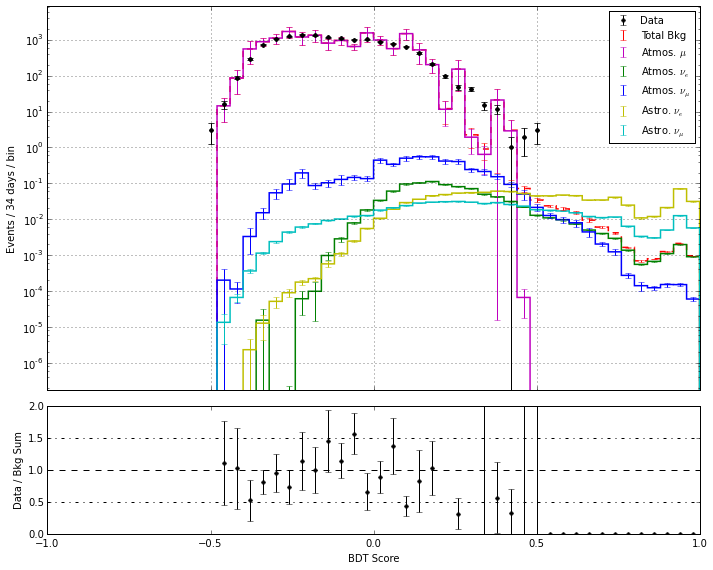

In [44]:
# Plot the scores
pt.plotStackedRatio(info,'scores','BDT Score', 50, -1, 1, 1e-10, True, False)
plt.savefig('../plots/mvaana/EffectiveArea/datamc_bdtscore.png')
plt.show()

In [ ]:
print sum(d_data['w']), sum(dt_bkg['w']), sum(dt_bkg['w'])/sum(d_data['w'])

In [69]:
# Methods to plot effective area
from math import pi,log10

xmin  = 3
xmax  = 7
nbins = 20.
bins = np.arange(3,9.1,0.3)
ebins_per_decade = float(nbins/(xmax-xmin))
solidangle = 4*pi

def mcLogEBin(E):
    return int(log10(E)*ebins_per_decade)
def mcEMin(mc_log_ebin):
    return pow(10,mc_log_ebin/ebins_per_decade)
def mcEMax(mc_log_ebin):
    return pow(10,(1+mc_log_ebin)/ebins_per_decade)

# Calculate effective area
def getEffA(data, isbdt):
    effA = np.zeros(len(data['PrimaryNeutrinoEnergy']),dtype=float)
    energy = np.empty(len(data['PrimaryNeutrinoEnergy']),dtype=float)        
    fnorm  = 1. / (C.nugen_nue_nfiles)
    
    dt_E = data['PrimaryNeutrinoEnergy'].as_matrix()
    dt_oneweight = data['OneWeight'].as_matrix()
    dt_nevents   = data['NEvents'].as_matrix()
    for i in range(len(effA)):

        E = dt_E[i]
        OneWeight = dt_oneweight[i]
        NEvents   = dt_nevents[i]
        mclogebin = mcLogEBin(E)
        mcemin = mcEMin(mclogebin)
        mcemax = mcEMax(mclogebin)
        
        sf = 1
        if isbdt and np.log10(E) >=6:
            sf = 1/0.4
        
        
        effA[i] = 1e-4 * OneWeight * fnorm/NEvents * 1/(solidangle*(mcemax-mcemin)) * sf
        energy[i] = log10(E)

    return effA, energy

def plotEffA(nrg, effa, col, lbl,ls='solid'):
        plt.hist(nrg,
                 weights=effa,
                 color=col,
                 label=lbl,
                 range=(xmin,xmax),
                 bins = nbins,
                 histtype='step',
                 lw = 1.5,
                ls = ls)


2.41125385174


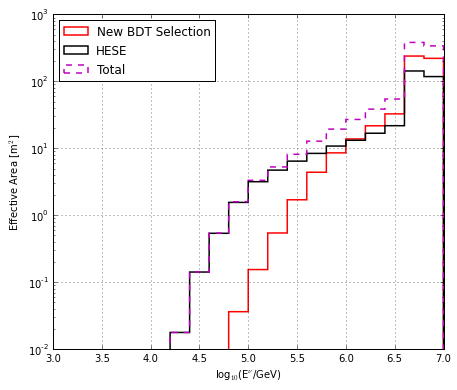

In [70]:
# Now plot the effective area for nu_e events from HESE
# and those passing the new BDT selection

# Load the hese data set
heseloader = Loader('(passHESE && nuE>0)')
dt_hese = heseloader.getNuE()

# Select off the nue events that pass the bdt cut
bdtcut = 0.7
nue_pass = dt_nue[ dt_nue['scores'] > bdtcut]
print sum(nue_pass['wE2']) *365/34.7

# Now evaluate effective area
new_effa, new_e = getEffA(nue_pass, True)
hese_effa, hese_e = getEffA(dt_hese, False)

# Now plot
fig,ax = plt.subplots(figsize=(7,6))
plotEffA(new_e, new_effa, 'r', 'New BDT Selection')
plotEffA(hese_e, hese_effa, 'black', 'HESE')
plotEffA(np.concatenate([new_e, hese_e]),
         np.concatenate([new_effa, hese_effa]),
         'm', 'Total','dashed')

ax.set_ylim([1e-2,1e3])
ax.set_yscale('log')
plt.xlabel(r'log$_{10}$(E$^{\nu}$/GeV)')
plt.ylabel(r'Effective Area [m$^{2}$]')
plt.grid()
plt.legend(loc='upper left')
plt.savefig('../plots/mvaana/EffectiveArea/effafirstpass.png')